# Match Reference and Gene Strokes Based on Stroke Error

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from random import randint, seed
from xmlparse import xmlToGeometry, loadScores, loadGeometry, loadRef

from score_strokes import alignStrokes

import numpy as np

2024-03-15T18:13:46.719170Z [INFO ] Stylus initialized - Stylus 1.5.0 [RELEASE - Aug 29 2023 15:40:46] (c) 2006-2009 Biologic Institute


In [2]:
"""
def loadRef(han_char, ref_dir = "Reference"):
    stroke_list = []
    frac_dists = []
    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"
    ref_xml = open(ref_path, "r").read()
    root = xmltodict.parse(ref_xml)
    bounds = root["hanDefinition"]["bounds"]
    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))
    scale = (int(x_max-x_min), int(y_max-y_min))
    strokes = root["hanDefinition"]["strokes"]["stroke"]
    for stroke in strokes:
        points = stroke["points"]["forward"]
        point_arr = []
        frac_arr = []
        for point in points["pointDistance"]:
            point_arr.append((float(point["@x"])-x_min,
                              float(point["@y"])-y_min))
            frac_arr.append(float(point["@fractionalDistance"]))
        stroke_list.append(np.array(point_arr))
        frac_dists.append(np.array(frac_arr))
    return stroke_list, frac_dists, scale

def loadGeometry(data_dir, han_char, output_size = (32, 32), f_read = None):
    ""
    Loads geometric data about a gene characetr directly from the XML source
    ""
    if f_read is None:
        dir_list = os.listdir(f"{data_dir}/{han_char}")
        dir_list.sort()
    else:
        dir_list = f_read
    g_data = []
    f_names = []
    for f in dir_list:
        flines = open(f"{data_dir}/{han_char}/{f}", "rb").readlines()
        f_names.append(flines[0].decode()[:-1])
    for f in f_names:
        g = xmlToGeometry(f, output_size)
        g_data.append(g)
    return g_data
"""


'\ndef loadRef(han_char, ref_dir = "Reference"):\n    stroke_list = []\n    frac_dists = []\n    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"\n    ref_xml = open(ref_path, "r").read()\n    root = xmltodict.parse(ref_xml)\n    bounds = root["hanDefinition"]["bounds"]\n    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))\n    scale = (int(x_max-x_min), int(y_max-y_min))\n    strokes = root["hanDefinition"]["strokes"]["stroke"]\n    for stroke in strokes:\n        points = stroke["points"]["forward"]\n        point_arr = []\n        frac_arr = []\n        for point in points["pointDistance"]:\n            point_arr.append((float(point["@x"])-x_min,\n                              float(point["@y"])-y_min))\n            frac_arr.append(float(point["@fractionalDistance"]))\n        stroke_list.append(np.array(point_arr))\n        frac_dists.append(np.array(frac_arr))\n    return stroke_list, frac_dists,

In [3]:
#ref_g, ref_l, output_size = loadRef("5E7E", "Reference")
# in order to test multiple samples, add the file numbers to the f_read list and delete the [0] at the line end
# be aware this will turn g and l into iterables, so handle your loops accordingly
#g, l = loadGeometry("Genes/sixgenes", "5E7E", output_size, f_read = ["11000"])[0]

In [4]:
def strokeErrorMatrix(strokes, ref, p_strokes, p_ref):
    error_map = np.zeros((len(ref), len(strokes)), dtype=float)
    matches_tried = np.zeros(len(strokes), dtype=int)
    for i, ref_stroke, r_progresses in zip(range(len(ref)), ref, p_ref):
        for j, candidate_stroke, c_progresses in zip(range(len(strokes)), strokes, p_strokes):
            error_map[i, j] = strokeError(ref_stroke, candidate_stroke, r_progresses, c_progresses)
    return error_map

def strokeError(stroke, ref_stroke, p_stroke, p_ref, mode="max"):
    forward_stroke_error, back_stroke_error = np.zeros(len(ref_stroke)), np.zeros(len(ref_stroke))
    forward_ref_error, back_ref_error = np.zeros(len(stroke)), np.zeros(len(stroke))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke, p_ref):
        forward_stroke_error[i] = np.linalg.norm((rpoint-strokeTrace(stroke, p_stroke, rprogress)))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke[::-1], p_ref[::-1]):
        back_stroke_error[i] = np.linalg.norm((rpoint-strokeTrace(stroke, p_stroke, 1-rprogress)))
    for i, point, progress in zip(range(len(stroke)), stroke, p_stroke):
        forward_ref_error[i] = np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, progress)))
    for i, point, progress in zip(range(len(stroke)), stroke[::-1], p_stroke[::-1]):
        back_ref_error[i] = np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, 1-progress)))
    final_error = min(max(forward_stroke_error.sum(), forward_ref_error.sum()), max(back_stroke_error.sum(), back_ref_error.sum()))
    return final_error

def strokeTrace(stroke, stroke_progresses, progress):
    if progress == 1:
        return stroke[-1]
    progress_line = len(stroke_progresses)-1
    for i in range(1, len(stroke_progresses)):
        if stroke_progresses[i] > progress:
            progress_line = i-1
            break
    startp, endp = stroke_progresses[progress_line], stroke_progresses[progress_line+1]
    norm_progress = (progress-startp)/endp
    if stroke[progress_line+1][0] == stroke[progress_line][0]:
        x = stroke[progress_line][0]
        y = norm_progress*(stroke[progress_line+1][1]-stroke[progress_line][1])+stroke[progress_line][0]
    else:
        slope = (stroke[progress_line+1][1]-stroke[progress_line][1])/(stroke[progress_line+1][0]-stroke[progress_line][0])
        intercept = stroke[progress_line][1]-slope*stroke[progress_line][0]
        x = norm_progress*(stroke[progress_line+1][0]-stroke[progress_line][0])+stroke[progress_line][0]
        y = slope*x + intercept
    return np.array((x, y))


In [5]:
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]

In [6]:
def visualizeMatch(han_char, match_char, f_num, ref_dir="Reference", data_dir="HanBitmap"):
    ref_g, ref_l, output_size = loadRef(han_char, ref_dir)
    g, l = loadGeometry(data_dir, han_char, output_size, f_read = [str(f_num)])[0]
    score = loadScores(data_dir, han_char, f_read = [str(f_num)])[0]
    alignments = alignStrokes(g, ref_g, l, ref_l)
    img = Image.new(mode="RGBA", size=output_size)
    seed(ref_l[0][0])
    colors = color_selection[:len(ref_l)+1]

    for x in range(len(alignments)):
        i = np.where(alignments == x)[0][0]
        draw = ImageDraw.Draw(img)
        for a in range(len(g[i])-1):
            x1, y1 = g[i][a]
            x2, y2 = g[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[x])
    
    
    for i in range(len(alignments)):
        draw = ImageDraw.Draw(img)
        for a in range(len(ref_g[i])-1):
            x1, y1 = ref_g[i][a]
            x2, y2 = ref_g[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            draw.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
            
    print(f"Mismatch for file number {f_num}, Stylus score {score}")
    display(img)

def visualizeMatchFile(han_char, match_char, gene_file, ref_dir="Reference", data_dir="HanBitmap"):
    ref_g, ref_l, output_size = loadRef(han_char, ref_dir)
    g, l = loadGeometry(data_dir, han_char, output_size, f_read = [gene_file])[0]
    score = loadScores(data_dir, f_read = [gene_file])[0]
    alignments = alignStrokes(g, ref_g, l, ref_l)
    img = Image.new(mode="RGBA", size=output_size)
    seed(ref_l[0][0])
    colors = color_selection[:len(ref_l)+1]

    print(alignments)
        
    for x in range(len(alignments)):
        i = np.where(alignments == x)[0][0]
        draw = ImageDraw.Draw(img)
        for a in range(len(g[i])-1):
            x1, y1 = g[i][a]
            x2, y2 = g[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[x])
    
    
    for i in range(len(alignments)):
        draw = ImageDraw.Draw(img)
        for a in range(len(ref_g[i])-1):
            x1, y1 = ref_g[i][a]
            x2, y2 = ref_g[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            draw.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
            
    print(f"Mismatch for file {gene_file}, Stylus score {score}")
    display(img)

[0 4 3 5 2 1]
Mismatch for file 5411.08.170.gene, Stylus score 0.4226127221195943


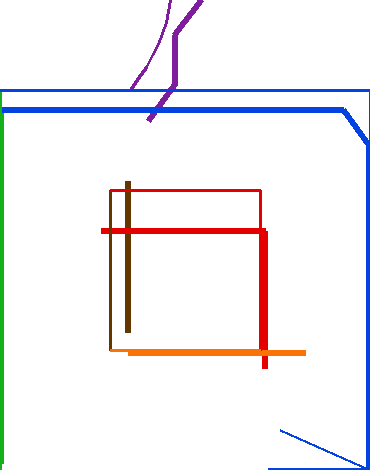

[0 4 3 5 2 1]
Mismatch for file 5411.08.171.gene, Stylus score 0.4033449394656553


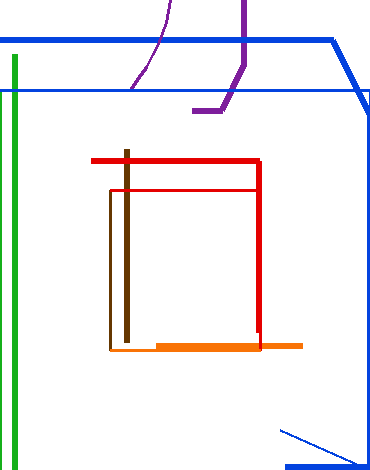

[0 4 3 5 2 1]
Mismatch for file 5411.08.66.gene, Stylus score 0.4161675323930796


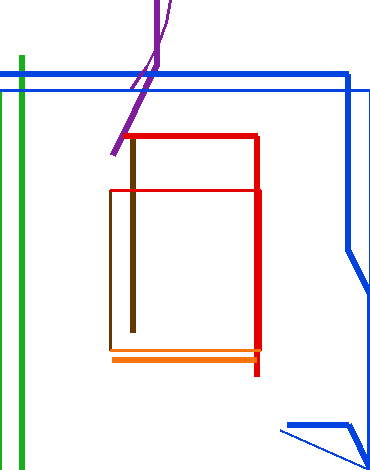

[0 4 3 5 2 1]
Mismatch for file 5411.08.89.gene, Stylus score 0.4015431525860935


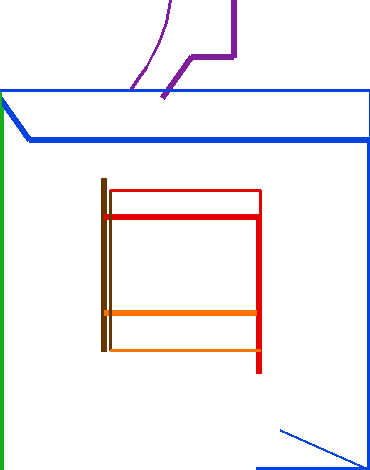

[0 4 3 5 2 1]
Mismatch for file 5411.08.90.gene, Stylus score 0.4067344564737693


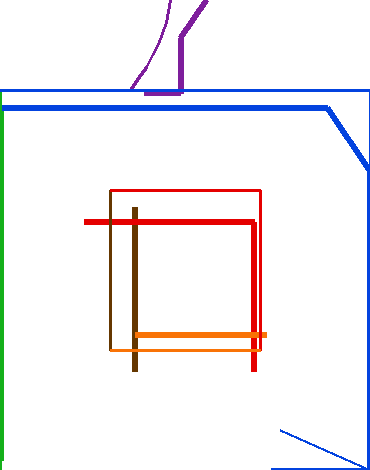

In [7]:
# Plot mismatches for mappings from high ranking genes onto themselves

"""
                        GeneID  4EFB  5408  5728  5B57  56E0  5411
79   0.4_5411_5411.08.170.gene  True  True  True  True  True  True
163   0.4_5411_5411.08.66.gene  True  True  True  True  True  True
188   0.4_5411_5411.08.89.gene  True  True  True  True  True  True
190   0.4_5411_5411.08.90.gene  True  True  True  True  True  True

                       GeneID  4EFB  5408  5728  5B57  56E0  5411
101  0.2_4EFB_4EFB.2.190.gene  True  True  True  True  True  True
112   0.2_4EFB_4EFB.2.20.gene  True  True  True  True  True  True
"""

mismatches = [
    "0.4_5411_5411.08.170.gene",
    "0.4_5411_5411.08.171.gene", #Control, wasn't originally errant
    "0.4_5411_5411.08.66.gene",
    "0.4_5411_5411.08.89.gene",
    "0.4_5411_5411.08.90.gene",
]
for gene_id in mismatches:
    gene_file = gene_id.split("_")[2]
    visualizeMatchFile("5411", "5411", gene_file, data_dir="Genes/6-stroke genes/min score 0.4/maint_0.4 on 5411.08")

[0 1 5 4 3 2]
Mismatch for file 4EFB.2.190.gene, Stylus score 0.2370366240530161


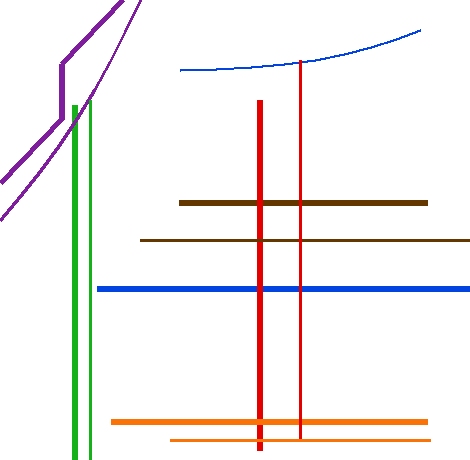

[0 1 5 4 3 2]
Mismatch for file 4EFB.2.20.gene, Stylus score 0.2014371047132829


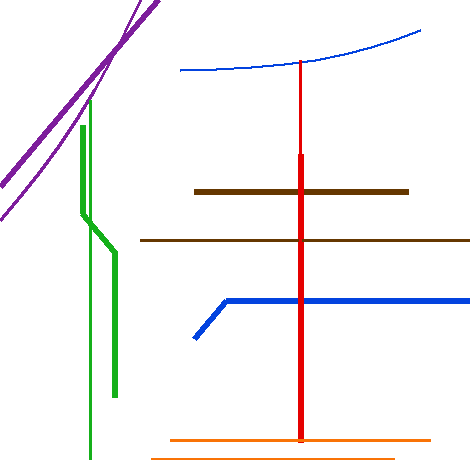

In [8]:
mismatches = [
    "0.2_4EFB_4EFB.2.190.gene",
    "0.2_4EFB_4EFB.2.20.gene",
]

for gene_id in mismatches:
    gene_file = gene_id.split("_")[2]
    visualizeMatchFile("4EFB", "4EFB", gene_file, data_dir="Genes/6-stroke genes/min score 0.2/maint_0.2 on 4EFB.2")

[0 1 5 4 2 3]
Mismatch for file 4EFB.02.191.gene, Stylus score 0.4107045653694715


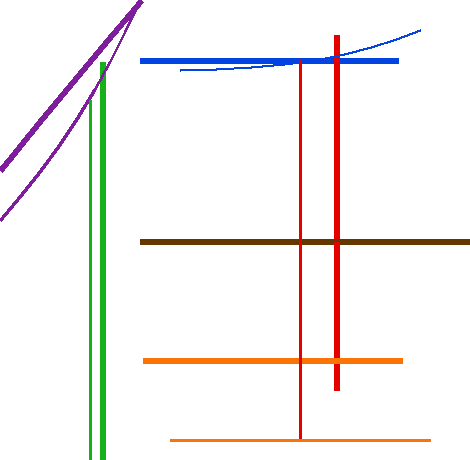

[0 1 5 4 2 3]
Mismatch for file 4EFB.02.24.gene, Stylus score 0.405221149692444


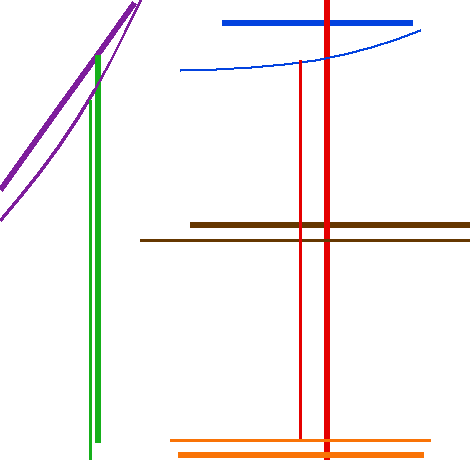

In [9]:
matches = [
    "0.2_4EFB_4EFB.02.191.gene",
    "0.2_4EFB_4EFB.02.24.gene",
]

for gene_id in matches:
    gene_file = gene_id.split("_")[2]
    visualizeMatchFile("4EFB", "4EFB", gene_file, data_dir="Genes/6-stroke genes/min score 0.4/maint_0.4 on 4EFB.02")